## Welcome and introduction
For this week's mini project, we're going to attempt the Kaggle 'Natural Language Processing with Disaster Tweets' competition.
This is a competition for building a machine learning model that predicts which tweets are about real disasters and which ones aren't.

This competition is currently running indefintely, as of today,and is available on [Kaggle](https://www.kaggle.com/c/nlp-getting-started).

For this project, we'll be utilizing a RNN Architecture and working to build a model that can detect which tweets are of real disasters and which aren't.

We ran this on Google Colab, and fetched the dataset directly from kaggle.

To fetch the dataset, you will need to get a kaggle API key.

## Imports
Import all libraries used in this notebook

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import os
import zipfile
import matplotlib.pyplot as plt
import itertools
import folium
import time

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Input, Concatenate, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter
from wordcloud import WordCloud
from google.colab import files
from geopy.geocoders import Nominatim
from IPython.display import display



## Fetch dataset
Fetch dataset from kaggle

In [ ]:
if not os.path.exists("kaggle.json") and not os.path.exists(".kaggle/kaggle.json"):
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
if not os.path.exists("dataset"):
    with zipfile.ZipFile("nlp-getting-started.zip", 'r') as zip_ref:
        zip_ref.extractall("dataset")

Download nltk stopwords. Used for pre-processing text

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
main_data = pd.read_csv('dataset/train.csv')

## Exploratory Data Analysis (EDA)
Let's explore the data to understand it's shape and more about how it's structured.

In [ ]:
print(main_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [ ]:
print(main_data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


Unique values and their counts:
target
0    4342
1    3271
Name: count, dtype: int64


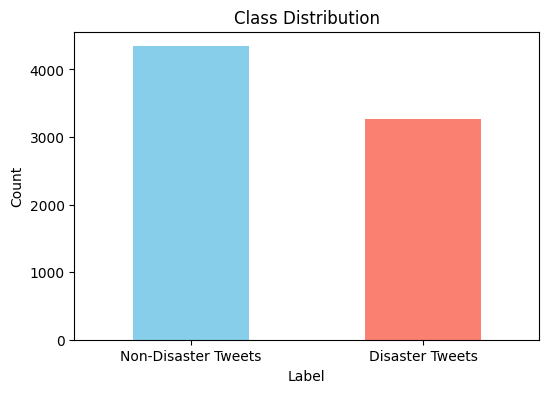

In [ ]:
label_counts = main_data['target'].value_counts()
print("Unique values and their counts:")
print(label_counts)

# Plot the distribution
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Disaster Tweets', 'Disaster Tweets'], rotation=0)
plt.show()

## Locations
Are there null locations?
How many unique locations are there?
What are some examples of location values?

In [ ]:
print("Number of missing locations:", main_data['location'].isnull().sum())  # Check for missing values
print("Number of unique locations:", main_data['location'].nunique())  # Unique values


Number of missing locations: 2533
Number of unique locations: 3341


In [ ]:
# Print 10 non null locations rows
print("10 non-null location rows:")
print(main_data['location'].dropna().sample(n=10, random_state=42))


10 non-null location rows:
3389                      Bend, Oregon
5602                          Erie, PA
71                       St. Louis, MO
1851                   Cleveland, Ohio
4547                            Mumbai
3314           FLYEST HIPPIE YOU KNOW 
6146                       ???  Dreamz
6057                         Newcastle
3628    Washington, DC & Charlotte, NC
2834                     San Francisco
Name: location, dtype: object


## View locations
Let's see where the tweets originate (or claim to orginate) from

In [ ]:
def show_map():
    # Step 1: Filter Non-Null Locations
    non_null_locations = main_data['location'].dropna().unique()

    # Step 2: Initialize Geocoder
    geolocator = Nominatim(user_agent="location_mapper")

    # Step 3: Function to Get Latitude and Longitude
    def get_coordinates(location):
        try:
            location_data = geolocator.geocode(location)
            if location_data:
                return (location_data.latitude, location_data.longitude)
        except Exception as e:
            pass
        return None

    # Step 4: Get Coordinates for Each Location
    location_coords = {}
    for loc in non_null_locations:
        #print(f"Fetching coordinates for: {loc}")
        coords = get_coordinates(loc)
        if coords:
            location_coords[loc] = coords
        time.sleep(1)  # Prevent rate-limiting

    # Step 5: Create a Folium Map
    map_ = folium.Map(location=[20, 0], zoom_start=2)  # Centered on the world map

    # Step 6: Add Markers for Each Location
    for loc, coords in location_coords.items():
        folium.Marker(
            location=coords,
            popup=loc,
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(map_)

    # Step 7: Display the Map in the Notebook
    display(map_)

show_map()

In [ ]:
# Function to count words in a string
def word_count(text):
    return len(text.split())

In [ ]:
first_data = main_data.copy()

## Text Column
Let's review the text column.
Some actions to perform include
* Ensure the text is in lowercase
* Remove extra spaces
* Remove special characters apart from # and @ which have special meanings in tweets
* Remove stopwords? We tried with and without stop words and the predictions didn't significantly change

In [ ]:
# 1. TEXT PREPROCESSING AND CLEANING
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s#@]', '', text)  # Remove special characters except # and @
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Function to remove stop words
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])

# Load dataset
#stop_words = set(stopwords.words('english'))
first_data['cleaned_text'] = first_data['text'].apply(preprocess_text)
#data['cleaned_text'] = data['cleaned_text'].apply(remove_stopwords)

print(first_data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                       cleaned_text  
0       1  our deeds are the reason of this #earthquake m...  
1       1              forest fire near la ronge sask canada  
2       1  all residents asked to shelter in place are be...  
3       1  13000 people receive #wildfires evacuation ord...  
4       1  just got sent this photo from ruby #alaska as ...  


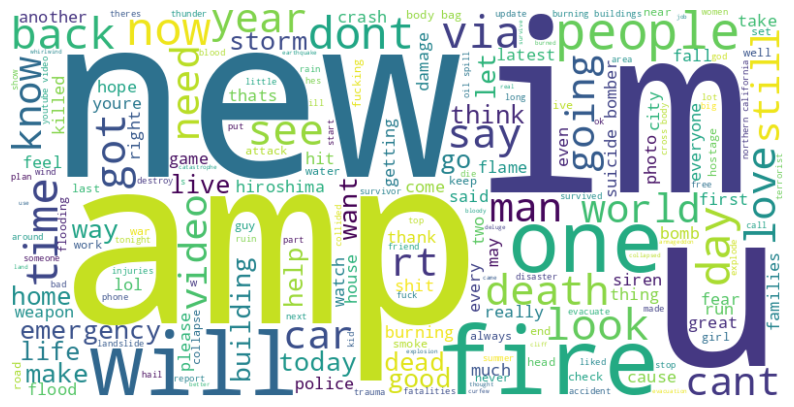

In [ ]:
text = " ".join(first_data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


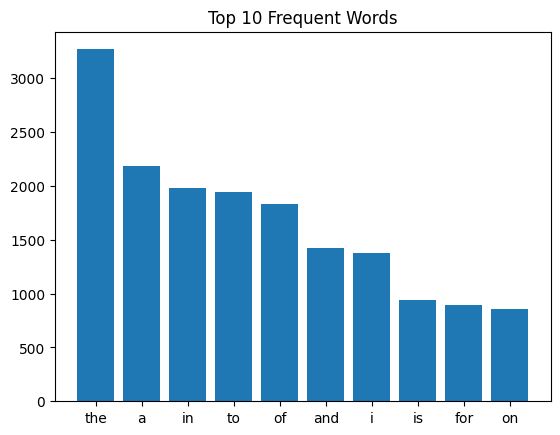

In [ ]:
all_words = " ".join(first_data['cleaned_text']).split()
word_freq = Counter(all_words).most_common(10)

words, counts = zip(*word_freq)
plt.bar(words, counts)
plt.title("Top 10 Frequent Words")
plt.show()


In [ ]:
# Apply the word count function to the 'cleaned_text' column
first_data['word_count'] = first_data['cleaned_text'].apply(word_count)

# Find max and min word counts
max_words = first_data['word_count'].max()
min_words = first_data['word_count'].min()

# Print results
print(f"Maximum number of words: {max_words}")
print(f"Minimum number of words: {min_words}")


Maximum number of words: 31
Minimum number of words: 1


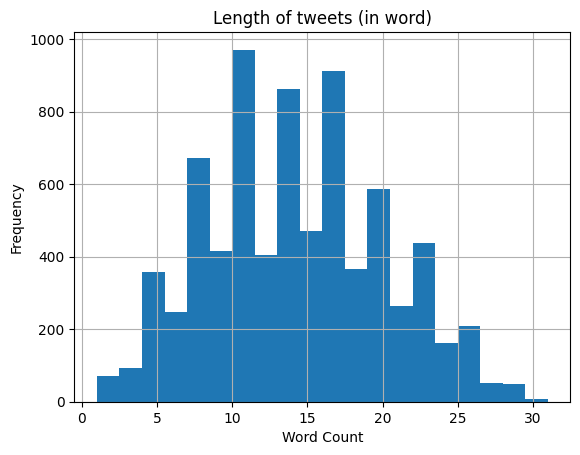

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                       cleaned_text  word_count  \
0       1  our deeds are the reason of this #earthquake m...          13   
1       1              forest fire near la ronge sask canada           7   
2       1  all residents asked to shelter in place are be...          22   
3       1  13000 people receive #wildfires evacuation ord...           8   
4       1  just got sent this photo from ruby #alaska as ...          16   

   text_length  
0           13  
1            7  
2           22  
3           

In [ ]:
first_data['text_length'] = first_data['cleaned_text'].apply(lambda x: len(x.split()))
first_data['text_length'].hist(bins=20)
plt.title("Length of tweets (in word)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

print(first_data.head())

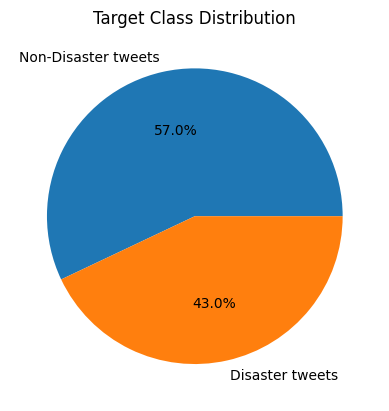

In [ ]:
plt.pie(first_data['target'].value_counts(),
        labels=['Non-Disaster tweets', 'Disaster tweets'],
        autopct='%1.1f%%')
plt.title("Target Class Distribution")
plt.show()


In [ ]:
# Prepare labels
le = LabelEncoder()
first_data['label'] = le.fit_transform(first_data['target'])

# Split data
X = first_data['cleaned_text']
y = first_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Function to boost words starting with '#' or '@'
def boost_hashtags(text):
    words = text.split()
    boosted_words = []
    for word in words:
        if word.startswith('#') or word.startswith('@'):
            boosted_words.extend([word] * 3)  # Duplicate hashtag words 3 times
        else:
            boosted_words.append(word)
    return ' '.join(boosted_words)

# Apply the boosting function to the training and test data
#X_train_boosted = X_train.apply(boost_hashtags)
#X_test_boosted = X_test.apply(boost_hashtags)

In [ ]:
print(X_train.head())
print(y_train.head())

4996    courageous and honest analysis of need to use ...
3263    @zachzaidman @670thescore wld b a shame if tha...
4907    tell @barackobama to rescind medals of honor g...
2855    worried about how the ca drought might affect ...
4716    @youngheroesid lava blast amp power red #panth...
Name: cleaned_text, dtype: object
4996    1
3263    0
4907    1
2855    1
4716    0
Name: label, dtype: int64


In [ ]:
def plot_training_history(history, title="Training and Validation Metrics"):
    """
    Plots training and validation loss and accuracy from a model's history object.

    Parameters:
    - history: History object returned by model.fit()
    - title: Title for the overall figure (default: "Training and Validation Metrics")
    """
    # Extract metrics
    epochs = range(1, len(history.history['loss']) + 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot Loss
    plt.figure(figsize=(12, 6))

    # Subplot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, linestyle='--', label='Training Loss', color='green')
    plt.plot(epochs, val_loss, linestyle='--', label='Validation Loss', color='orange')
    plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
    plt.title("Model Loss and Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.grid()

    # Add overall title and show the plots
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title
    plt.show()

## TF-IDF VECTORIZATION
TF-IDF is a technique used to evaluate the importance of a word in a document relative to a collection of documents.

TF-IDF works by identifying the most important words by using their frequency in a single document and their rarity across the corpus.

In [ ]:
# TF-IDF VECTORIZATION
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Tokenization for deep learning models
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1



In [ ]:
# Padding
max_len = max_words
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

print(X_train_seq.shape)

(6090, 31)


## Model Architecture
We'll begin with a simple LSTM model. We use the Sequential class to stack layers linearly.
We have four layers
* Embedding - Convert word indices into continuous vector embeddings
* LSTM - Captures dependencies and relationships in the data
* Dropout - Set to 0.5 (50%). Prevents overfitting be randomly turning off neurons during training
* Dense - Converts output to a probability between 0 an 1

In [ ]:
# LSTM MODEL
def build_lstm():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Train LSTM
lstm_model = build_lstm()
lstm_model.fit(X_train_seq,
               y_train,
               epochs=5,
               batch_size=32,
               verbose=1,
               validation_split=0.1)

# Evaluate LSTM
y_pred_lstm = (lstm_model.predict(X_test_seq) > 0.5).astype(int)
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.6082 - loss: 0.6574 - val_accuracy: 0.7931 - val_loss: 0.4765
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8759 - loss: 0.3309 - val_accuracy: 0.7997 - val_loss: 0.4704
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9471 - loss: 0.1651 - val_accuracy: 0.7521 - val_loss: 0.5566
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9601 - loss: 0.1268 - val_accuracy: 0.7586 - val_loss: 0.5982
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9703 - loss: 0.0894 - val_accuracy: 0.7849 - val_loss: 0.7044
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
LSTM Accuracy: 0.7852921864740644


## Hyperparameter Tuning
Let's run some experiments on the various hyperparameters.
We can compare their performance against each other.

In [ ]:
# Hyperparameter combinations
embedding_dims = [64, 128]
lstm_units = [32, 64, 128]
dropout_rates = [0.3, 0.5]
batch_sizes = [32, 64]
epochs_list = [5, 10]

# To store results
results = []
best_val_accuracy = 0
best_model = None
best_model_history = None

# Function to build LSTM model with hyperparameters
def build_lstm(embedding_dim, lstm_unit, dropout_rate):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        LSTM(lstm_unit, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Grid search over hyperparameter combinations
for embedding_dim, lstm_unit, dropout_rate, batch_size, epochs in itertools.product(
        embedding_dims, lstm_units, dropout_rates, batch_sizes, epochs_list):

    print(f"Training model with embedding_dim={embedding_dim}, lstm_unit={lstm_unit}, "
          f"dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}")

    # Build model
    model = build_lstm(embedding_dim, lstm_unit, dropout_rate)

    # Add EarlyStopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Fit the model
    history = model.fit(
        X_train_seq, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=0,
        callbacks=[early_stop]
    )

    # Get the best validation accuracy from training history
    val_accuracy = max(history.history['val_accuracy'])
    train_accuracy = max(history.history['accuracy'])

    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Store results
    results.append({
        'embedding_dim': embedding_dim,
        'lstm_unit': lstm_unit,
        'dropout_rate': dropout_rate,
        'batch_size': batch_size,
        'epochs': epochs,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy
    })

    # Check if this is the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model  # Store the best model

lstm_model = best_model
# Print the best-performing model
best_result = max(results, key=lambda x: x['val_accuracy'])
print("\nBest Model Hyperparameters:")
print(best_result)

# Sort results by 'val_accuracy' in descending order and print the top 5 results
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)
print("\nTop 5 Models by Validation Accuracy:")
for i, result in enumerate(sorted_results[:5], start=1):
    print(f"Rank {i}: {result}")

# Evaluate the best model on the test set
y_pred_best = (best_model.predict(X_test_seq) > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_pred_best)
print(f"\nTest Accuracy of Best Model: {test_accuracy:.4f}")


Training model with embedding_dim=64, lstm_unit=32, dropout_rate=0.3, batch_size=32, epochs=5
Validation Accuracy: 0.8046
Training model with embedding_dim=64, lstm_unit=32, dropout_rate=0.3, batch_size=32, epochs=10
Validation Accuracy: 0.8227
Training model with embedding_dim=64, lstm_unit=32, dropout_rate=0.3, batch_size=64, epochs=5
Validation Accuracy: 0.8095
Training model with embedding_dim=64, lstm_unit=32, dropout_rate=0.3, batch_size=64, epochs=10
Validation Accuracy: 0.8062
Training model with embedding_dim=64, lstm_unit=32, dropout_rate=0.5, batch_size=32, epochs=5
Validation Accuracy: 0.8030
Training model with embedding_dim=64, lstm_unit=32, dropout_rate=0.5, batch_size=32, epochs=10
Validation Accuracy: 0.8161
Training model with embedding_dim=64, lstm_unit=32, dropout_rate=0.5, batch_size=64, epochs=5
Validation Accuracy: 0.7947
Training model with embedding_dim=64, lstm_unit=32, dropout_rate=0.5, batch_size=64, epochs=10
Validation Accuracy: 0.8013
Training model with 

## Add more layers to the model
What happens when we add more layers to our model architecture?


Training model with 1 LSTM layer(s)...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Train Accuracy: 0.9599, Val Accuracy: 0.8095, Test Accuracy: 0.8050

Training model with 2 LSTM layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Train Accuracy: 0.9584, Val Accuracy: 0.8227, Test Accuracy: 0.8076

Training model with 3 LSTM layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Train Accuracy: 0.9345, Val Accuracy: 0.7997, Test Accuracy: 0.8017

Training model with 4 LSTM layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Train Accuracy: 0.9423, Val Accuracy: 0.7964, Test Accuracy: 0.7951

Training model with 5 LSTM layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Train Accuracy: 0.9392, Val Accuracy: 0.8013, Test Accuracy: 0.8024

Training model with 6 LSTM layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Train Accuracy: 0.9405, Val Accuracy: 0.7931, Test Accuracy: 0.7840


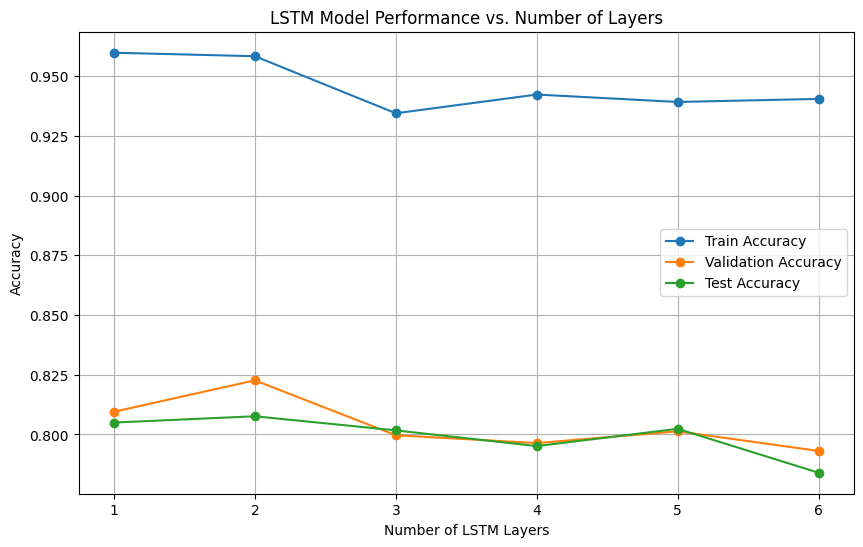


Final Results:
   num_layers  train_accuracy  val_accuracy  test_accuracy
0           1        0.959861      0.809524       0.804990
1           2        0.958402      0.822660       0.807617
2           3        0.934501      0.799672       0.801707
3           4        0.942346      0.796387       0.795141
4           5        0.939245      0.801314       0.802364
5           6        0.940522      0.793103       0.783979


In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(lstm_unit, return_sequences=False),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

def build_lstm_with_layers(layers):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=best_result['embedding_dim']))

    for i in range(layers):
        return_seq = i < layers - 1
        model.add(LSTM(best_result['lstm_unit'], return_sequences=return_seq))
        model.add(Dropout(best_result['dropout_rate']))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Evaluate models with different LSTM layer counts
results = []
num_layers_list = list(range(1, 7))  # LSTM layers from 1 to 6
optimal_layers = 0
layers_top_accuracy = 0
best_lstm_history = None

for num_layers in num_layers_list:
    print(f"\nTraining model with {num_layers} LSTM layer(s)...")

    # Build and train the model
    model = build_lstm_with_layers(num_layers)
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(X_train_seq, y_train, epochs=5, batch_size=32,
                        validation_split=0.1, verbose=0, callbacks=[early_stop])

    # Evaluate on test data
    y_pred = (model.predict(X_test_seq) > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test, y_pred)

    if test_accuracy > layers_top_accuracy:
        layers_top_accuracy = test_accuracy
        optimal_layers = num_layers
        best_lstm_history = history

    # Store results
    results.append({
        'num_layers': num_layers,
        'train_accuracy': max(history.history['accuracy']),
        'val_accuracy': max(history.history['val_accuracy']),
        'test_accuracy': test_accuracy
    })

    print(f"Train Accuracy: {results[-1]['train_accuracy']:.4f}, "
          f"Val Accuracy: {results[-1]['val_accuracy']:.4f}, "
          f"Test Accuracy: {test_accuracy:.4f}")

# Convert results to a DataFrame for easy visualization
import pandas as pd
results_df = pd.DataFrame(results)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(results_df['num_layers'], results_df['train_accuracy'], label='Train Accuracy', marker='o')
plt.plot(results_df['num_layers'], results_df['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(results_df['num_layers'], results_df['test_accuracy'], label='Test Accuracy', marker='o')

plt.title("LSTM Model Performance vs. Number of Layers")
plt.xlabel("Number of LSTM Layers")
plt.ylabel("Accuracy")
plt.xticks(results_df['num_layers'])
plt.legend()
plt.grid()
plt.show()

# Display results
print("\nFinal Results:")
print(results_df)


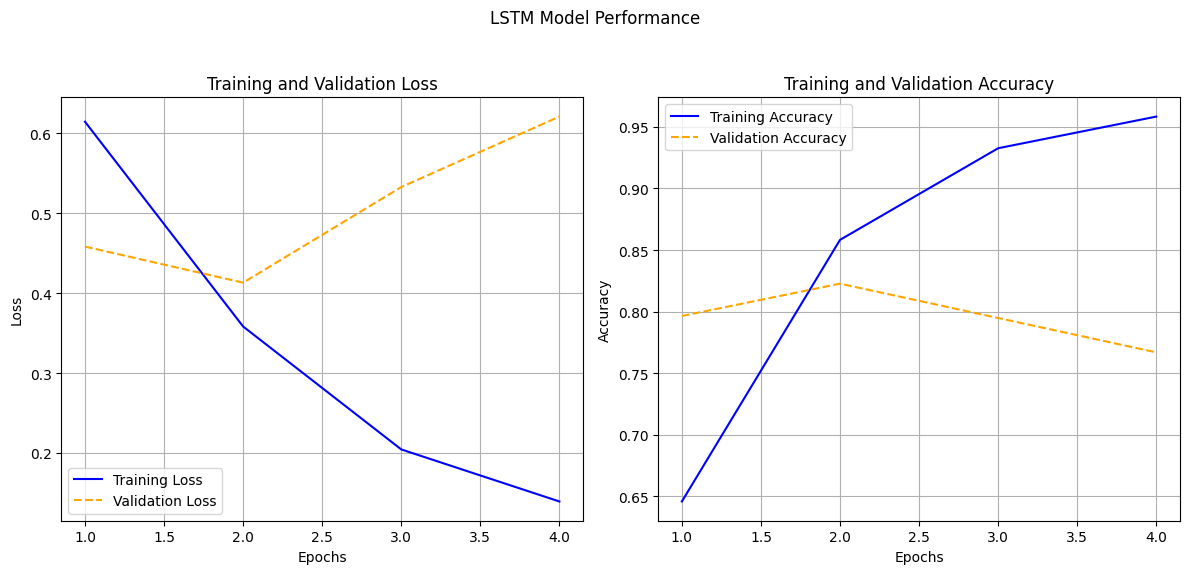

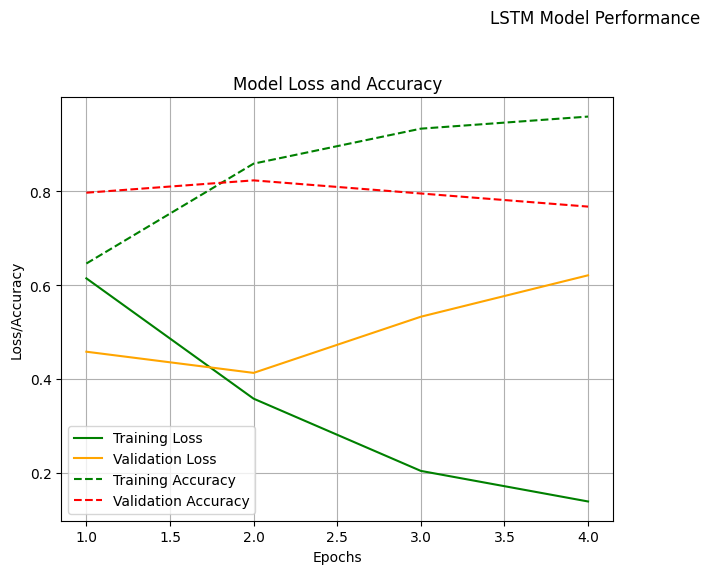

In [ ]:
# Plot Loss
plot_training_history(best_lstm_history, title="LSTM Model Performance")

## Compare with Bidirectional LSTM model
Let's compare with a Bidirectional LSTM model

Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.5844 - loss: 0.6700 - val_accuracy: 0.7635 - val_loss: 0.5219
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8662 - loss: 0.3525 - val_accuracy: 0.8112 - val_loss: 0.4265
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9414 - loss: 0.1869 - val_accuracy: 0.7767 - val_loss: 0.4888
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9614 - loss: 0.1248 - val_accuracy: 0.7635 - val_loss: 0.6092
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9781 - loss: 0.0804 - val_accuracy: 0.7652 - val_loss: 0.7007
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
LSTM Test Accuracy: 0.7741300065659882
Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.6390 - loss: 0.6254 - val_accuracy: 0.7964 - val_loss: 0.4245
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8806 - loss: 0.2998 - val_accuracy: 0.7833 - val_loss: 0.4686
Epoch 3/5
172/172 ━━

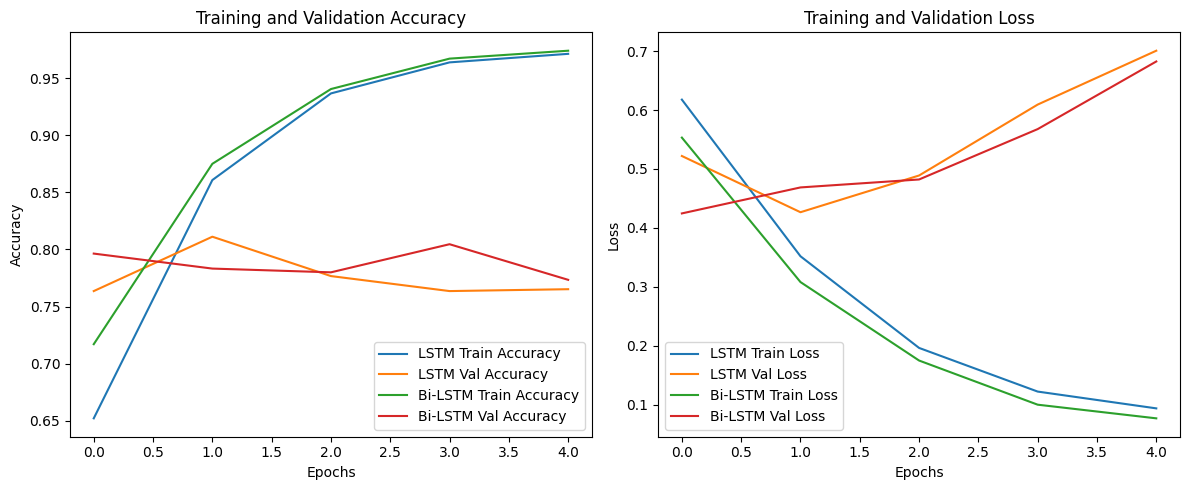

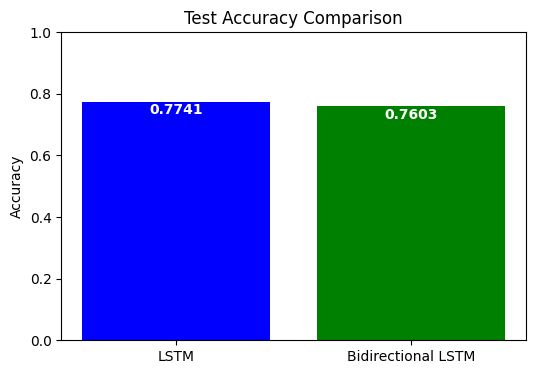

In [ ]:
def build_lstm():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train LSTM
lstm_model = build_lstm()
history_lstm = lstm_model.fit(X_train_seq, y_train, epochs=5, batch_size=32, verbose=1, validation_split=0.1)

# Evaluate LSTM
y_pred_lstm = (lstm_model.predict(X_test_seq) > 0.5).astype(int)
lstm_test_accuracy = accuracy_score(y_test, y_pred_lstm)
print("LSTM Test Accuracy:", lstm_test_accuracy)

def build_lstm_b():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train LSTM
lstm_model_b = build_lstm_b()
history_lstm_b = lstm_model_b.fit(X_train_seq, y_train, epochs=5, batch_size=32, verbose=1, validation_split=0.1)

# Evaluate LSTM
y_pred_lstm_b = (lstm_model_b.predict(X_test_seq) > 0.5).astype(int)
lstm_b_test_accuracy = accuracy_score(y_test, y_pred_lstm_b)
print("Bidirectional LSTM Test Accuracy:", lstm_b_test_accuracy)


# Visualizations
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val Accuracy')
plt.plot(history_lstm_b.history['accuracy'], label='Bi-LSTM Train Accuracy')
plt.plot(history_lstm_b.history['val_accuracy'], label='Bi-LSTM Val Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.plot(history_lstm_b.history['loss'], label='Bi-LSTM Train Loss')
plt.plot(history_lstm_b.history['val_loss'], label='Bi-LSTM Val Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Bar Chart for Test Accuracy Comparison
plt.figure(figsize=(6, 4))
models = ['LSTM', 'Bidirectional LSTM']
test_accuracies = [lstm_test_accuracy, lstm_b_test_accuracy]

plt.bar(models, test_accuracies, color=['blue', 'green'])
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Accuracy scale
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc - 0.05, f"{acc:.4f}", ha='center', va='bottom', color='white', fontweight='bold')
plt.show()

## Let's try the GRU model
Let's build a GRU model and also experiment with various layers in our GRU model

In [ ]:
# GRU MODEL
def build_gru():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        GRU(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train GRU
gru_model = build_gru()
gru_model.fit(X_train_seq, y_train, epochs=5, batch_size=32, verbose=1, validation_split=0.1)

# Evaluate GRU
y_pred_gru = (gru_model.predict(X_test_seq) > 0.5).astype(int)
print("GRU Accuracy:", accuracy_score(y_test, y_pred_gru))

# Compare Results
print("Final Results:")
print(f"LSTM Accuracy: {accuracy_score(y_test, y_pred_lstm)}")
print(f"GRU Accuracy: {accuracy_score(y_test, y_pred_gru)}")


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.5693 - loss: 0.6868 - val_accuracy: 0.5698 - val_loss: 0.6844
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5754 - loss: 0.6809 - val_accuracy: 0.5698 - val_loss: 0.6826
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.6878 - loss: 0.5838 - val_accuracy: 0.8128 - val_loss: 0.4202
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9026 - loss: 0.2655 - val_accuracy: 0.8046 - val_loss: 0.4659
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.9582 - loss: 0.1324 - val_accuracy: 0.7816 - val_loss: 0.5334
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
GRU Accuracy: 0.7662508207485227
Final Results:
LSTM Accuracy: 0.7741300065659882
GRU Accuracy: 0.7662508207485227



Training model with 1 GRU layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Train Accuracy: 0.9405, Val Accuracy: 0.7931, Test Accuracy: 0.7958

Training model with 2 GRU layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Train Accuracy: 0.9405, Val Accuracy: 0.7931, Test Accuracy: 0.7978

Training model with 3 GRU layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
Train Accuracy: 0.9405, Val Accuracy: 0.7931, Test Accuracy: 0.7971

Training model with 4 GRU layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step
Train Accuracy: 0.9405, Val Accuracy: 0.7931, Test Accuracy: 0.7827

Training model with 5 GRU layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step
Train Accuracy: 0.9405, Val Accuracy: 0.7931, Test Accuracy: 0.7951

Training model with 6 GRU layer(s)...
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step
Train Accuracy: 0.9405, Val Accuracy: 0.7931, Test Accuracy: 0.7814


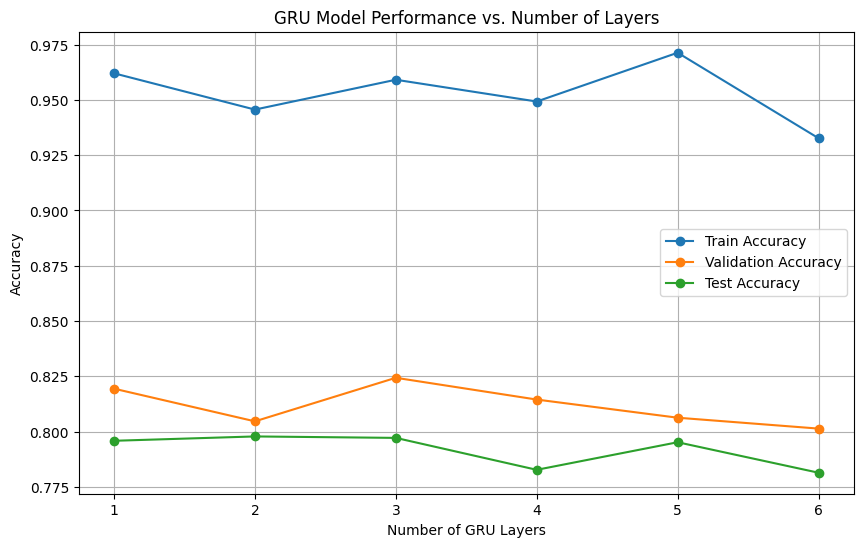


Final Results:
   num_layers  train_accuracy  val_accuracy  test_accuracy
0           1        0.962051      0.819376       0.795798
1           2        0.945630      0.804598       0.797768
2           3        0.959132      0.824302       0.797111
3           4        0.949279      0.814450       0.782666
4           5        0.971356      0.806240       0.795141
5           6        0.932676      0.801314       0.781353


In [ ]:
def build_gru_with_layers(layers):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128))

    for i in range(layers):
        return_seq = i < layers - 1
        model.add(GRU(64, return_sequences=return_seq))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Evaluate models with different GRU layer counts
results_grus = []
best_gru_history = None
best_gru_accuracy = 0
num_layers_list_grus = list(range(1, 7))  # GRU layers from 1 to 6

for num_layers in num_layers_list_grus:
    print(f"\nTraining model with {num_layers} GRU layer(s)...")

    # Build and train the model
    model = build_gru_with_layers(num_layers)
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(X_train_seq, y_train, epochs=5, batch_size=32,
                        validation_split=0.1, verbose=0, callbacks=[early_stop])

    # Evaluate on test data
    y_pred = (model.predict(X_test_seq) > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test, y_pred)

    if test_accuracy > best_gru_accuracy:
        best_gru_accuracy = test_accuracy
        best_gru_history = history

    # Store results
    results_grus.append({
        'num_layers': num_layers,
        'train_accuracy': max(history.history['accuracy']),
        'val_accuracy': max(history.history['val_accuracy']),
        'test_accuracy': test_accuracy
    })

    print(f"Train Accuracy: {results[-1]['train_accuracy']:.4f}, "
          f"Val Accuracy: {results[-1]['val_accuracy']:.4f}, "
          f"Test Accuracy: {test_accuracy:.4f}")

# Convert results to a DataFrame for easy visualization
import pandas as pd
results_df_grus = pd.DataFrame(results_grus)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(results_df_grus['num_layers'], results_df_grus['train_accuracy'], label='Train Accuracy', marker='o')
plt.plot(results_df_grus['num_layers'], results_df_grus['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(results_df_grus['num_layers'], results_df_grus['test_accuracy'], label='Test Accuracy', marker='o')

plt.title("GRU Model Performance vs. Number of Layers")
plt.xlabel("Number of GRU Layers")
plt.ylabel("Accuracy")
plt.xticks(results_df_grus['num_layers'])
plt.legend()
plt.grid()
plt.show()

# Display results
print("\nFinal Results:")
print(results_df_grus)

## Analysis
Compare the best performing LSTM vs the best performing GRU


In [ ]:
import matplotlib.pyplot as plt

def plot_multiple_model_histories(histories, labels):
    """
    Function to plot the training and validation accuracy and loss
    for multiple model.fit histories.

    Parameters:
    - histories: List of History objects from model.fit()
    - labels: List of labels (strings) corresponding to each model
    """
    # Ensure the number of histories and labels match
    if len(histories) != len(labels):
        raise ValueError("Number of histories and labels must match.")

    #epochs = range(1, len(histories[0].history['accuracy']) + 1)  # Number of epochs
    # Determine the minimum number of epochs across all histories
    max_epochs = max([len(history.history['accuracy']) for history in histories])
    min_epochs = min([len(history.history['accuracy']) for history in histories])
    #print(f"Max: {max_epochs}, Min: {min_epochs}")
    epochs = range(1, min_epochs + 1)  # Adjusted to the shortest history

    # Plot Accuracy
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(epochs, history.history['accuracy'][:min_epochs], label=f'{label} Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'][:min_epochs], linestyle='--', label=f'{label} Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(epochs, history.history['loss'][:min_epochs], label=f'{label} Training Loss')
        plt.plot(epochs, history.history['val_loss'][:min_epochs], linestyle='--', label=f'{label} Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Example Usage:
# Assume `history_lstm`, `history_bilstm`, and `history_gru` are history objects from model.fit()



Max: 5, Min: 4


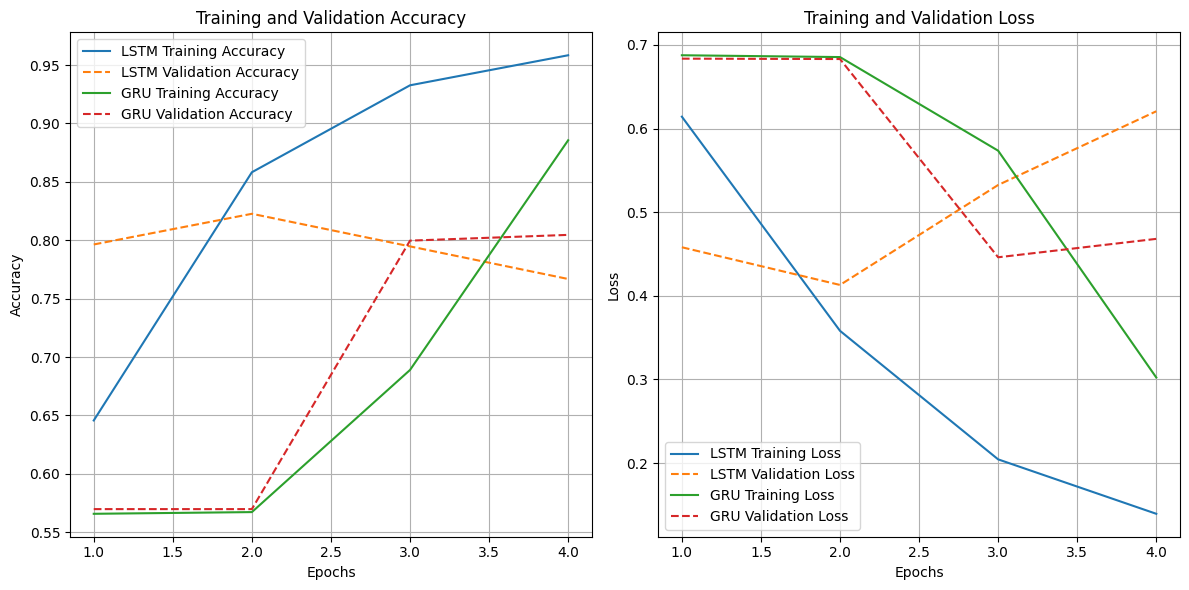

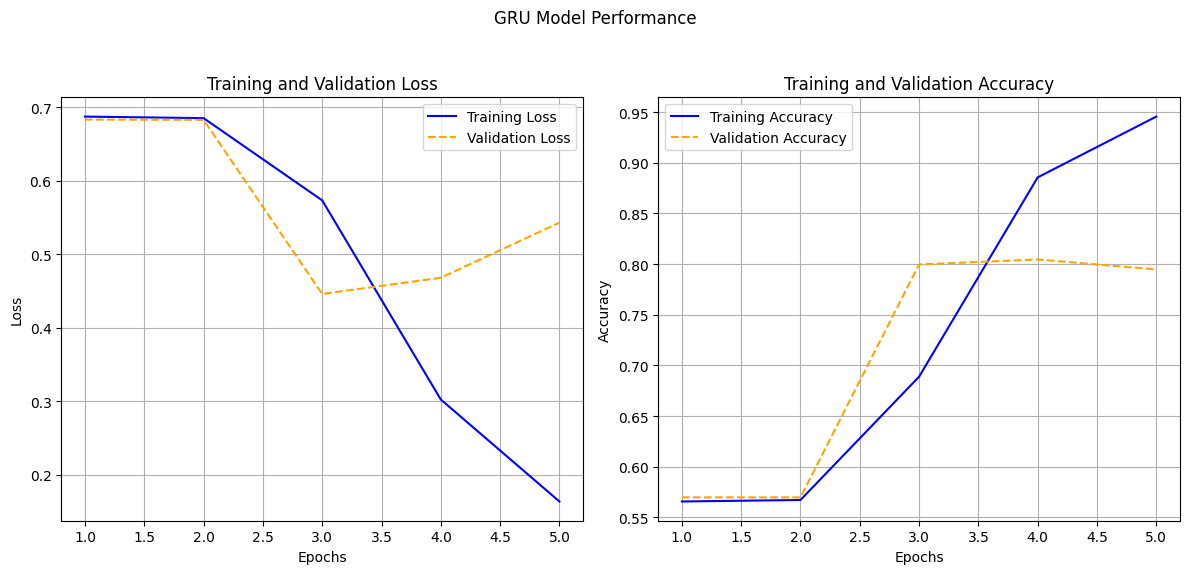

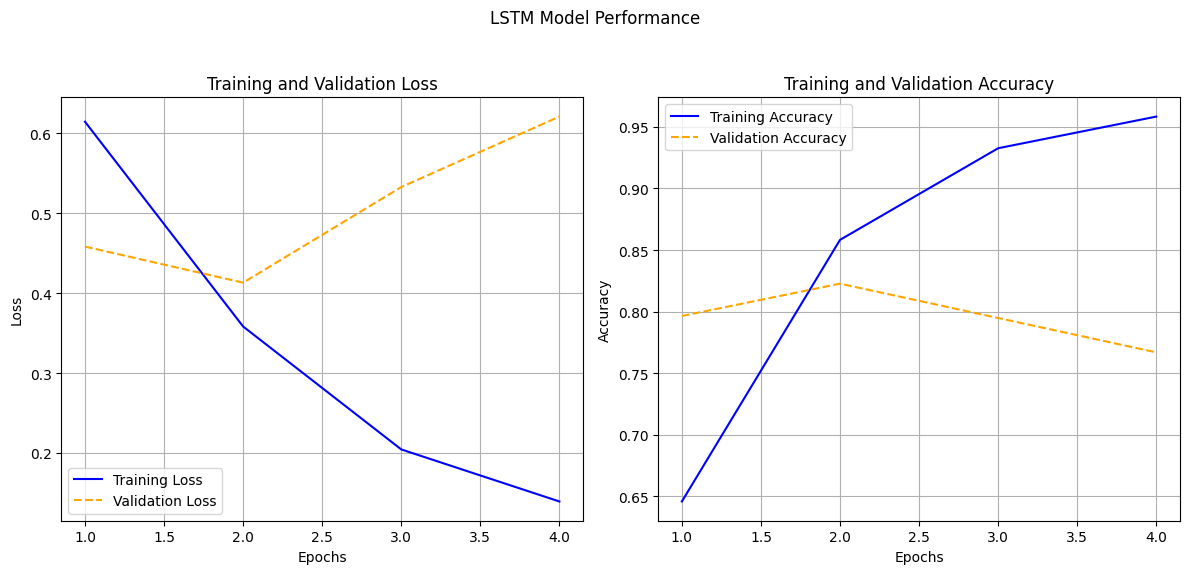

In [ ]:
plot_training_history(best_gru_history, title="GRU Model Performance")
plot_training_history(best_lstm_history, title="LSTM Model Performance")

## Tests

## GloVe vs TF-IDF
Finally, let's switch from TF-IDF to GloVe if that will have a marked improvement on results.

In [ ]:
if not os.path.exists("glove.6B.50d.txt"):
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove.6B.zip


In [ ]:
# Load GloVe embeddings into a dictionary
embedding_index = {}
with open("glove.6B.100d.txt", "r", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


In [ ]:
embedding_dim = 100  # GloVe dimension
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
lstm_glove_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_glove_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_glove_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_65 (Embedding)             │ ?                           │       1,544,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_73 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,544,300 (5.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,544,300 (5.89 MB)

In [ ]:
# Train LSTM
lstm_glove_history = lstm_glove_model.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=1, validation_split=0.1)

# Evaluate LSTM
y_pred_lstm_glove = (lstm_glove_model.predict(X_test_seq) > 0.5).astype(int)
print("LSTM Glove Accuracy:", accuracy_score(y_test, y_pred_lstm_glove))
lstm_glove_accuracy = accuracy_score(y_test, y_pred_lstm_glove)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6464 - loss: 0.6163 - val_accuracy: 0.7980 - val_loss: 0.4735
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8031 - loss: 0.4705 - val_accuracy: 0.8062 - val_loss: 0.4606
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8215 - loss: 0.4218 - val_accuracy: 0.8177 - val_loss: 0.4331
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8243 - loss: 0.4110 - val_accuracy: 0.8046 - val_loss: 0.4299
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8313 - loss: 0.3987 - val_accuracy: 0.8046 - val_loss: 0.4611
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8515 - loss: 0.3723 - val_accuracy: 0.8161 - val_loss: 0.4557
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8427 - loss: 0.3838 - val_accuracy: 0.8046 - val_loss: 0.4758
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8520 - loss: 0.3455 - val_accu

## Comparison
Let's compare this with LSTM and GRU with TF-IDF

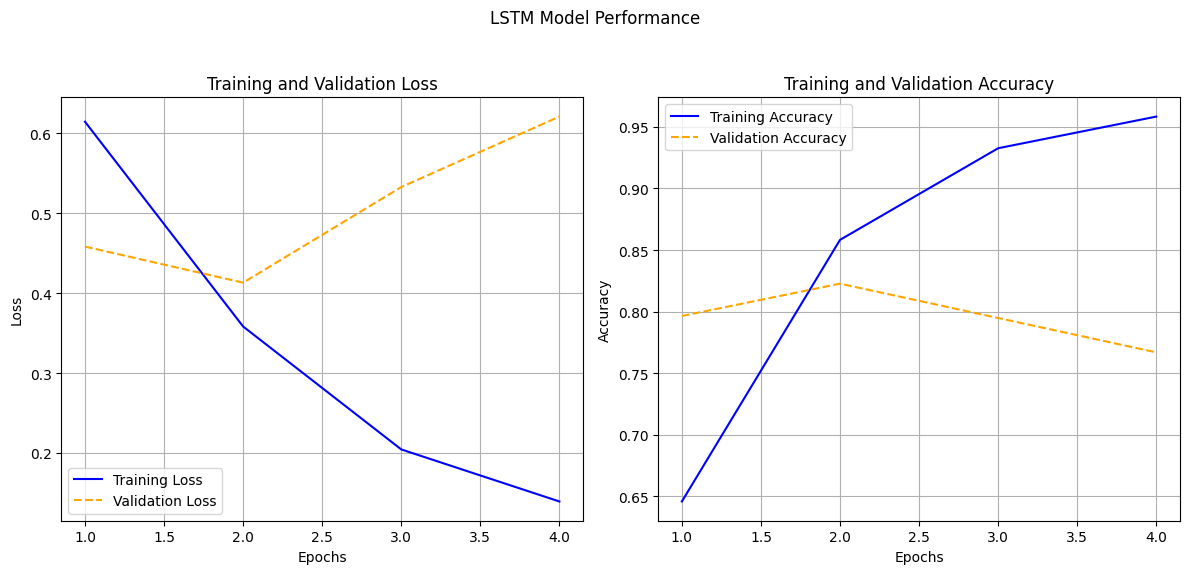

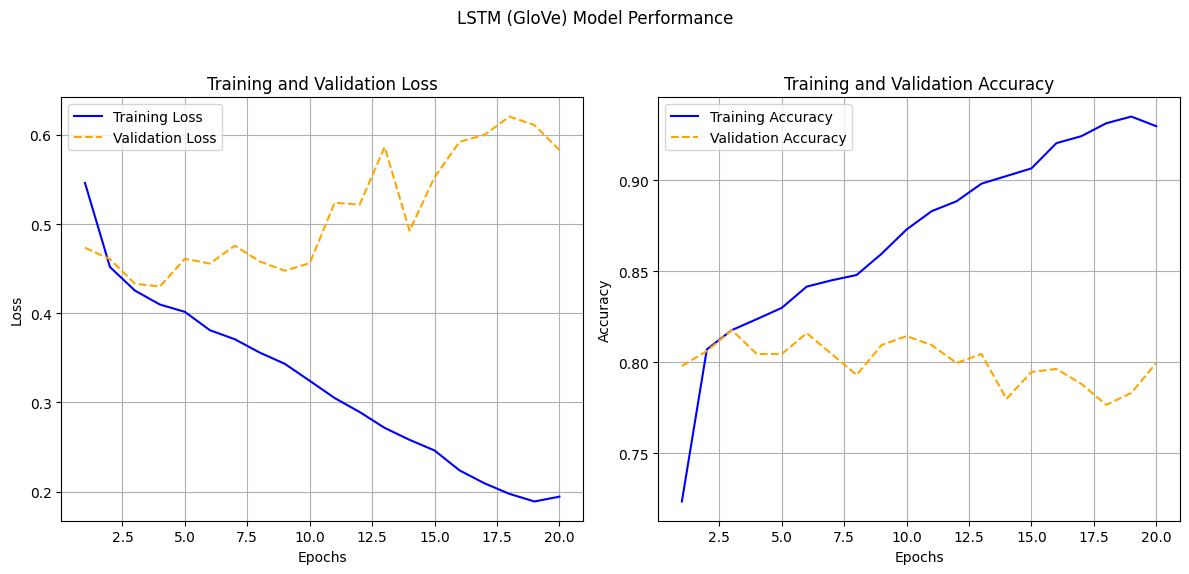

In [ ]:
plot_training_history(best_lstm_history, title="LSTM Model Performance")
plot_training_history(lstm_glove_history, title="LSTM (GloVe) Model Performance")

## Conclusion
For all the models we tested, the accuarcy of the training model increases steadily with an increase in epochs, however, the validation accuracy tapers off at about 0.80.

We tried tuning the hyperparameters, but we've been unable to significantly increase our prediction accuracy

## Future work
Some work we can do in the future to increase our score include
* Include location in the model
* Check if location is a real location and add to the model